# **EXPLORATORY DATA ANALYSIS**

In [3]:
#pip install -r requirements.txt

In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re #regular expressions library for text manipulation
import string
import numpy as np
import unicodedata
import ast

from prettytable import PrettyTable

import csv
import os
import random

from glob import glob

#NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
import emoji
import contractions

import itertools
from autocorrect import Speller

#for wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
#additional nlp models
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 1.4 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
def clean_comments (filepath):
    """
    import comments from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `isSubmitter`,
    
    remove duplicates, etc
    
    """
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df[df.Body != '[removed]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
    
    
        
    return df



In [4]:
def clean_submissions(filepath):
    """
    import submissions/posts from csv file into pandas dataframe,
    
    and carry out initial cleaning including removing deleted comments,
    
    correcting datetime data type, remove unwanted columns like `Unnamed`,
    
    remove duplicates, etc
    
    """
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df
    

In [5]:
#access dataset files
folder_path = os.path.join("..", "Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../Data/subset_sample_no_label.csv',
 '../Data/filtered_corpus.csv',
 '../Data/full_posts.csv',
 '../Data/full_data_no_preprocessing.csv',
 '../Data/posts_upvote_ratio.csv',
 '../Data/sub_upvotes.csv',
 '../Data/training_data.csv',
 '../Data/lda_train.csv',
 '../Data/vocabulary.csv',
 '../Data/emoji_subset.csv',
 '../Data/sampled_subset.csv',
 '../Data/subs_topics.csv',
 '../Data/comments.csv']

In [6]:
#import raw data and get num of rows
raw_comments = pd.read_csv('../Data/comments.csv')
raw_submissions = pd.read_csv('../Data/full_posts.csv')

/var/folders/b8/lw1d456n3zv1tb19_0tkz8_80000gn/T/ipykernel_30561/2004366255.py:2: DtypeWarning: Columns (0,4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_comments = pd.read_csv('../Data/comments.csv')


In [7]:
comments_filepath = '../Data/comments.csv'
submissions_filepath = '../Data/full_posts.csv'


data = pd.concat([clean_comments(comments_filepath), clean_submissions(submissions_filepath)], ignore_index = True)

data.head()

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅


In [8]:
#data.to_csv('../Data/full_data_no_preprocesing.csv')

<h2> Details of Data </h2>

In [9]:
#create table headings
data_summary = PrettyTable(['', 'raw_data', 'clean_data'])

#create row labels
data_summary.add_row(['posts',len (raw_submissions), len(data[data.text_type =='submission'])])
data_summary.add_row(['comments',len (raw_comments), len(data[data.text_type =='comment'])])
data_summary.add_row(['========','========','========'])
data_summary.add_row(['total', (len(raw_submissions)+ len(raw_comments)), 
                      (len(data[data.text_type =='submission'])+ len(data[data.text_type =='comment']))])

print (data_summary)

+----------+----------+------------+
|          | raw_data | clean_data |
+----------+----------+------------+
|  posts   |   4255   |    4255    |
| comments |  129521  |   124628   |
| ======== | ======== |  ========  |
|  total   |  133776  |   128883   |
+----------+----------+------------+


In [8]:
#table of entries per year
year_group = data.groupby(by='year')

entries_per_year = PrettyTable(['year', 'entries'])
for year, group in year_group:
    entries_per_year.add_row([year, len(group)])

print (entries_per_year)

+------+---------+
| year | entries |
+------+---------+
| 2012 |    11   |
| 2013 |    60   |
| 2014 |   143   |
| 2015 |   203   |
| 2016 |   786   |
| 2017 |   1127  |
| 2018 |   1676  |
| 2019 |   4217  |
| 2020 |  29760  |
| 2021 |  28034  |
| 2022 |  36342  |
| 2023 |  26524  |
+------+---------+


## **DATA DISTRIBUTION**

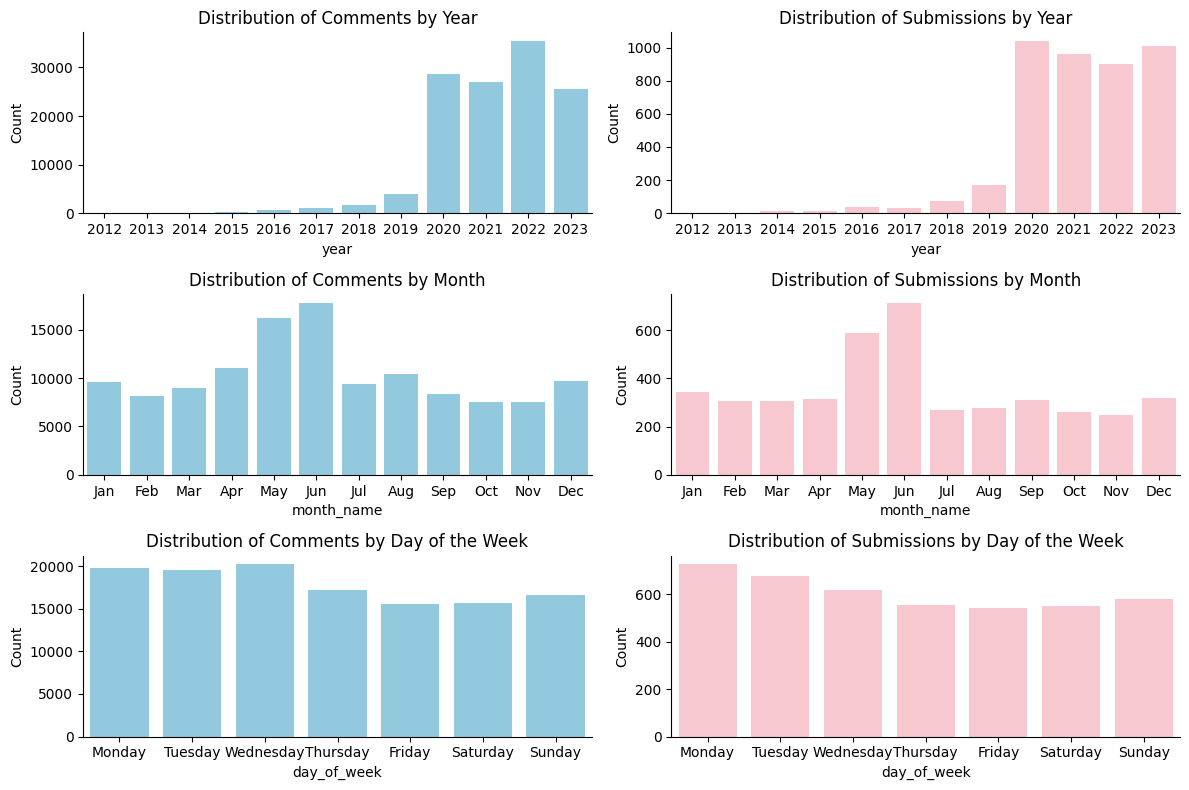

In [9]:
# showing temporal distribution of data

# Creating new columns for month and day of the week
data['month'] = data['date_created'].dt.month
data['day_of_week'] = data['date_created'].dt.day_name()
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
data['month_name'] = data['month'].replace(month_mapping)

# Filtering data for comments and submissions
comments_data = data[data['text_type'] == 'comment']
submissions_data = data[data['text_type'] == 'submission']

#function to plot distribution
def plot_distribution(data, title,color, ax):
    # plot the data 
    sns.countplot(data=data, x='year', color = color, ax=ax[0])
    sns.countplot(data=data, x='month_name', color =color, 
                  order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                      ax=ax[1])
    sns.countplot(data=data, x='day_of_week', 
                  order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                  color = color, ax=ax[2])
    #plot design
    for axis in ax:
        axis.set_ylabel('Count')
        axis.spines['top'].set_visible(False)  # Remove top border
        axis.spines['right'].set_visible(False)  # Remove right border
    ax[0].set_title(f'Distribution of {title} by Year')
    ax[1].set_title(f'Distribution of {title} by Month')
    ax[2].set_title(f'Distribution of {title} by Day of the Week')

# Plotting the distribution for comments and submissions with consistent colors
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

#set colors
com_color = "skyblue"
sub_color = 'pink'

#display the plots
plot_distribution(comments_data, "Comments", com_color, axes[:, 0])
plot_distribution(submissions_data, "Submissions", sub_color,  axes[:, 1])

plt.tight_layout()
plt.show()


### **Most Frequent Words**

#### **Without Removing stop words**

In [10]:
#list of all words in the dataframe
all_words = [word for sentence in data['long_text'] for word in sentence.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

common_words = fdist.most_common(10)

#table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in common_words:
    common_words_table.add_row([word, count])

print (common_words_table)

+------+--------+
| word | count  |
+------+--------+
| the  | 121075 |
|  to  | 90303  |
|  a   | 74823  |
| and  | 72887  |
|  I   | 61390  |
|  in  | 51342  |
|  of  | 50302  |
| you  | 49058  |
|  is  | 48783  |
| for  | 37280  |
+------+--------+


#### **stop words removed**

In [17]:
# Load spaCy model
nlp = spacy.load("en_core_web_md")

# Access spaCy's collection of stop words
stop_words = nlp.Defaults.stop_words

# Create a list of all words in the dataframe, excluding stop words
all_words = [word for sentence in data['long_text'] for word in sentence.split() if word.lower() not in stop_words]

# Frequency of word occurrence
fdist = FreqDist(all_words)

common_words = fdist.most_common(10)

# Table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in common_words:
    common_words_table.add_row([word, count])

print(common_words_table)

+--------+-------+
|  word  | count |
+--------+-------+
|  like  | 12400 |
| people | 12238 |
| Dubai  |  7401 |
|  know  |  6930 |
| don't  |  6702 |
| think  |  5840 |
|  it's  |  5768 |
|   -    |  5626 |
|  good  |  4958 |
|  I'm   |  4851 |
+--------+-------+


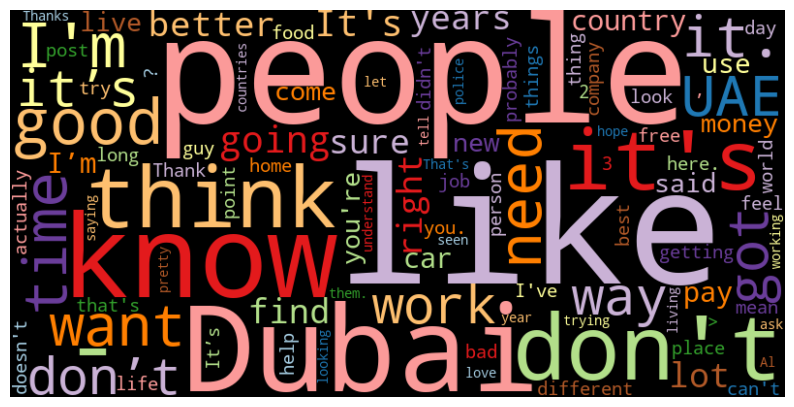

In [22]:
#wordcloud of most frequent words
# Create a dictionary of rare words and their frequencies
common_words = fdist.most_common(100)
common_word_freq = {word: freq for word, freq in common_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,  background_color="black", colormap="Paired").generate_from_frequencies(common_word_freq)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

fig.savefig('word_cloud_unprocessed_data.png', dpi = 300)

plt.show()



## **Rare Words**

In [24]:
rare_words = fdist.most_common()[:-100:-1]

#table of the rare words 
rare_words_table = PrettyTable(['word', 'count'])
for word, count in rare_words:
    rare_words_table.add_row([word,count])

#print (rare_words_table)

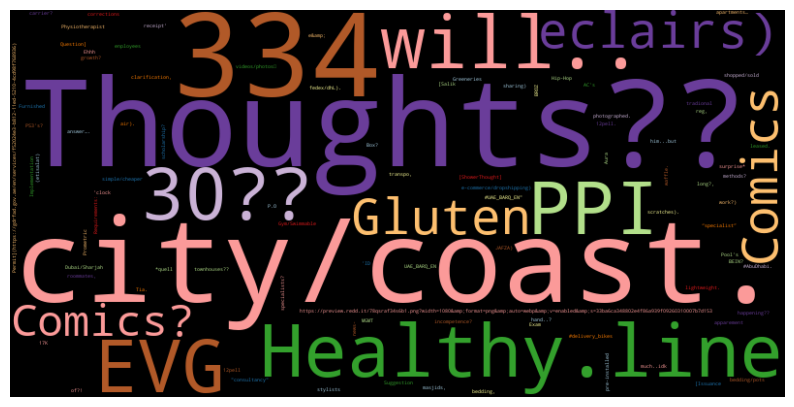

In [26]:
#a wordcloud of the rare words

# Create a dictionary of rare words and their frequencies
rare_word_freq = {word: freq for word, freq in rare_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Paired").generate_from_frequencies(rare_word_freq)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

fig.savefig('word_cloud_rare_words_unprocessed_data.png', dpi = 300)
plt.show()


In [28]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


lda_data = pd.read_csv('../Data/lda_train.csv', converters ={'tokens':list_converter})

In [29]:
lda_data.head()

,index,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
0,2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel cuntry past,"[single, travel, cuntry, past]",4
1,5,comment,gthiiwi,2021-04-05 23:18:56,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious spring souk,"[absolutely, hilarious, spring, souk]",4
2,13,comment,gtgfl4c,2021-04-05 18:21:42,2021,Is reel cinema and roxy part of emaar?,reel cinema roxy emaar,"[reel, cinema, roxy, emaar]",4
3,18,comment,gth5wdv,2021-04-05 21:42:41,2021,An innocent redditor here...can someone pls ex...,innocent redditor explain everyday,"[innocent, redditor, explain, everyday]",4
4,28,comment,gtfs2hs,2021-04-05 14:05:30,2021,Really? In springs souk? I never noticed it be...,spring souk notice cinema covid,"[spring, souk, notice, cinema, covid]",5


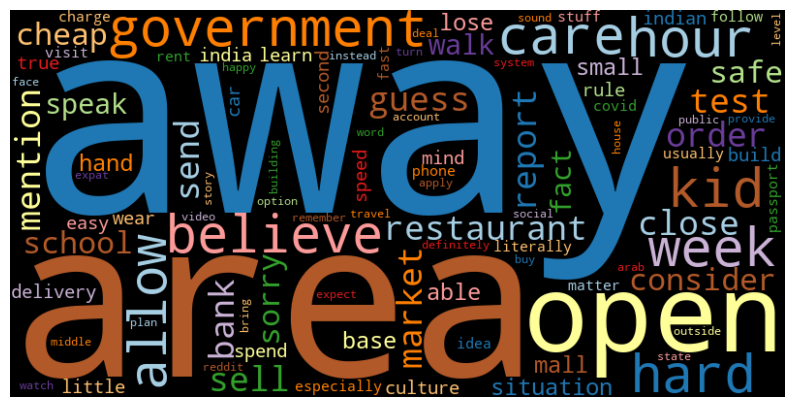

In [31]:
# Create a list of all words in the dataframe, excluding stop words
all_words = [word for token_row in lda_data['tokens'] for word in token_row]

# Frequency of word occurrence
fdist = FreqDist(all_words)

common_words = fdist.most_common(100)

#wordcloud of most frequent words
# Create a dictionary of rare words and their frequencies
common_word_freq = {word: freq for word, freq in common_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400,  background_color="black", colormap="Paired").generate_from_frequencies(common_word_freq)

# Plot the word cloud
fig = plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

fig.savefig("word_cloud_processed_data.png")
plt.show()